In [1]:
cd /data/store01/data_dirs/students/ucfafyi/S2_MODIS

/data/store01/data_dirs/students/ucfafyi/S2_MODIS


In [2]:
import sys
sys.path.insert(0,'python')
from Py6S import *
import gp_emulator
import pickle
from functools import partial
import pylab as plt
from scipy.stats import linregress
%matplotlib inline
import numpy as np

In [3]:
S2_RSRs = pickle.load(open('Nov_ipynb/S2_RSRs.pkl', 'r'))

In [6]:
S2_RSRs[6]

(13,
 0.84799999999999998,
 0.88049999999999995,
 array([ 0.00165148,  0.03804429,  0.21657728,  0.68010578,  0.91494435,
         0.92785929,  0.94658315,  0.96995952,  0.98332461,  0.99423704,
         0.92100462,  0.3551352 ,  0.04609595,  0.00463711]))

In [129]:
def atm(p, RSR = None):
    #print len(p[0])
    # ele in km
    TOA_ref , aot550, water, ozone, sz , vz , ele= p[0]
    
    path = '/home/ucfafyi/DATA/Downloads/6SV2.1/sixsV2.1'
    s = SixS(path)
    ss = []
    s = SixS(path)
    s.altitudes.set_target_custom_altitude(ele)
    s.altitudes.set_sensor_satellite_level()
    s.ground_reflectance = GroundReflectance.HomogeneousLambertian(GroundReflectance.GreenVegetation)
    s.geometry = Geometry.User()
    s.geometry.solar_a = 0
    s.geometry.solar_z = np.arcsin(sz)*180/np.pi
    s.geometry.view_a = 0
    s.geometry.view_z = np.arcsin(vz)*180/np.pi
    s.wavelength = Wavelength(RSR)
    s.aero_profile = AeroProfile.PredefinedType(AeroProfile.Continental)
    s.aot550 = aot550
    s.atmos_profile = AtmosProfile.UserWaterAndOzone(water, ozone)
    s.atmos_corr = AtmosCorr.AtmosCorrLambertianFromReflectance(TOA_ref)
    s.run()
    return s.outputs.atmos_corrected_reflectance_lambertian

In [130]:
parameters = ['TOA_ref','aot550', 'water', 'ozone', 'sz','vz','ele']
min_vals = [0.,0.,0., 0., 0., 0., 0]
max_vals = [1,1.,10., 1, 1, 1, 2]

In [ ]:
n_train =1000
n_validate = 500
retval = []
for band in range(7):
    simulator = partial (atm, RSR=S2_RSRs[band])
    x = gp_emulator.create_emulator_validation ( simulator, parameters, min_vals, max_vals, 
                                                n_train, n_validate, do_gradient=True, n_tries=15, n_procs=16)
    retval.append(x)

In [ ]:
retval

In [ ]:
from fastRWpkl import *
parallel_rw_pkl(retval, 'Sixs_emulation', 'w')

 1 &    nan &    nan &    nan &    nan &    nan\\
2 &    nan &    nan &    nan &    nan &    nan\\
3 &    nan &    nan &    nan &    nan &    nan\\
4 &  0.001 &  1.525 &  0.010 & 5.689e-03 & 8.085e+02\\
5 &    nan &    nan &    nan &    nan &    nan\\
6 & -0.000 &  0.000 & -0.001 & 4.103e-11 & 9.007e+01\\
7 & -0.000 &  0.000 & -0.000 & 4.478e-09 & 1.416e+03\\


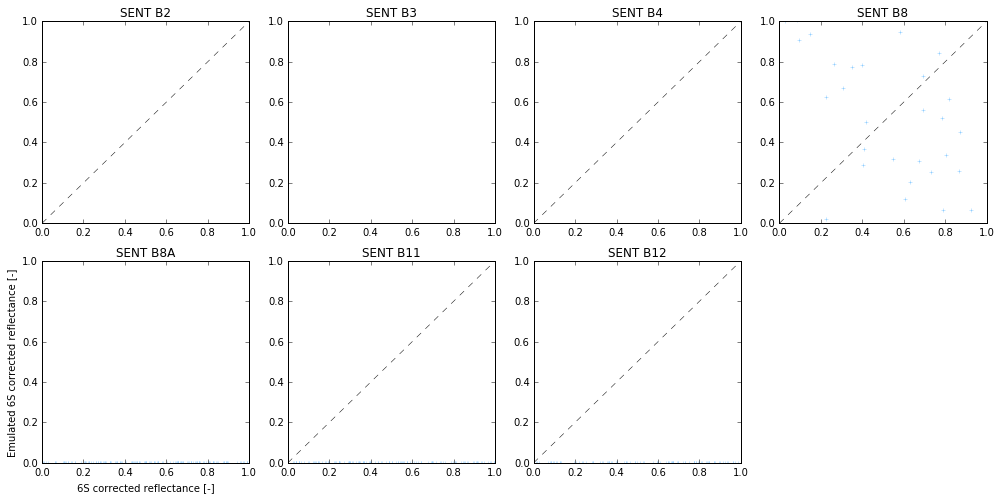

In [116]:
fig1, axs1 = plt.subplots ( nrows=2, ncols=4, figsize=(14,7))
#fig2, axs2 = plt.subplots ( nrows=4, ncols=3, figsize=(9,9))
axs1 = axs1.flatten()
#axs2 = axs2.flatten()
names = ('SB2_MB3,SB3_MB4,SB4_MB1,SB8_MB2,SB8A_MB2,SB11_MB6,SB12_MB7').split(',')

for iband in xrange (7):
    gp, validate, validate_output, validate_gradient, emulated_validation, emulated_gradient = retval[iband]

    slope, intercept, r_value, p_value, std_err = linregress( validate_output, emulated_validation.squeeze() )
    axs1[iband].plot ( validate_output, emulated_validation, '+', mec="#90ceff", mfc="none", rasterized=True, markersize= 4 )
    ymax = max(validate_output.max(), emulated_validation.max())
    if iband == 2:
        ymax = ymax*1.7
    axs1[iband].plot ( [0, 1.2*ymax], [0, 1.2*ymax], 'k--', lw=0.5)
    #p = np.polyfit ( validate_output, emulated_validation, 1)
    mae = np.abs(validate_output- emulated_validation.squeeze()).max()
    print "%d & %6.3f & %6.3f & %6.3f & %6.3e & %6.3e\\\\" % (iband+1, slope, intercept, r_value, std_err, mae),
    ymax = 1
    x = np.linspace(0, 1.1/1.2, 5)
    #axs1[iband].plot ( x, np.polyval ( p, x), '-', lw=0.4  )
    axs1[iband].set_ylim ( 0, ymax )
    axs1[iband].set_xlim ( 0, ymax )
    #pretty_axes ( axs1[iband])
    axs1[iband].set_title ('SENT %s'%(names[iband][1:-4]))
    print
axs1[4].set_ylabel ( "Emulated 6S corrected reflectance [-]")
axs1[4].set_xlabel ( "6S corrected reflectance [-]")
plt.tight_layout()     
axs1[7].set_visible (False)